In [142]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [143]:
import mdtraj as md
from sklearn.pipeline import Pipeline
from msmbuilder.io import load_trajs, load_meta, preload_tops, load_generic
from msmbuilder.feature_extraction import DihedralFeaturizer
from msmbuilder.feature_selection import VarianceThreshold
from msmbuilder.preprocessing import RobustScaler
from msmbuilder.decomposition import tICA
import numpy as np

## Load data

In [144]:
def get_timings(meta):
    frames_tot = meta['nframes'].sum()
    n_frames = meta['nframes'].unique()
    assert (len(n_frames) == 1, 'Different trajectory lengths')
    n_frames = n_frames[0]
    dt = meta['step_ps'][0]
    to_ns = dt/1000
    t_max = n_frames*to_ns
    return to_ns, t_max, frames_tot


def traj_load(irow):
    i, row = irow
    traj = md.load(row['traj_fn'], top=tops[row['top_fn']])
    return i, traj


<ipython-input-144-b7f0c528c48c>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(n_frames) == 1, 'Different trajectory lengths')


In [145]:
meta = load_meta('meta.pandas.pickl')
tops = preload_tops(meta)
trajs = [md.load(row['traj_fn'], top=tops[row['top_fn']], stride=1) 
         for i, row in meta.iterrows()]

## Get internal coordinates

In [146]:
bonds = load_generic('proc_traj/2agy_as-1_bonds.pickl')
angles = load_generic('proc_traj/2agy_as-1_angles.pickl')
dihedrals = load_generic('proc_traj/2agy_as-1_dihedrals.pickl')

## Featurize


In [147]:
def compute_dihedrals(traj, indices):
    dihedrals = md.compute_dihedrals(traj, indices=indices)
    dihedrals = np.concatenate((np.cos(dihedrals), np.sin(dihedrals)), axis=1)
    return dihedrals

def compute_angles(traj, indices):
    angles = md.compute_angles(traj, angle_indices=indices)
    angles = np.concatenate((np.cos(angles), np.sin(angles)), axis=1)
    return angles



In [148]:
from msmbuilder.feature_extraction import FunctionFeaturizer, AtomPairsFeaturizer
from msmbuilder.feature_selection import FeatureSelector

dihedrals_feat = FunctionFeaturizer(compute_dihedrals, func_args={'indices': dihedrals})
angles_feat = FunctionFeaturizer(compute_angles, func_args={'indices': angles})
bonds_feat = AtomPairsFeaturizer(pair_indices=bonds, periodic=True)


In [149]:
features = FeatureSelector([('bonds', bonds_feat), ('angles', angles_feat), ('dihedrals', dihedrals_feat)], 
                         which_feat=['angles'])
featurize = Pipeline([('features', features), ('variance', VarianceThreshold()), ('scaling', RobustScaler())])
to_ns, t_max, frames_tot = get_timings(meta)


In [150]:
def get_max_gap(evs, which=0):
    """
    returns n = number of components and spectral gap
    """
    ratios = evs[:-1]-evs[1:]
    return (np.argsort(ratios)[::-1][which]+1, ratios[np.argsort(ratios)[::-1][which]])

## Choose tICA parameters

In [151]:
all_features = ['angles', 'bonds', 'dihedrals']

for feature in all_features:
    featurize.set_params(features__which_feat=feature)
    print('Running {}'.format(feature))
    featurize.fit(trajs)
    ftrajs = featurize.transform(trajs)
    lags = np.arange(int(10/to_ns), int(51/to_ns), int(10/to_ns))
    n_comps = 10
    eigenvalues = np.zeros((lags.shape[0],n_comps))
    gaps = np.zeros(lags.shape[0])
    comps = np.zeros(lags.shape[0])
    for idx, lag in enumerate(lags):
        print('\t running lag {}'.format(lag))
        tica = tICA(n_components=n_comps, lag_time=lag, kinetic_mapping=True)
        tica.fit(ftrajs)
        evs = tica.eigenvalues_
        eigenvalues[idx] = evs
        n, gap = get_max_gap(evs)
        gaps[idx] = gap
        comps[idx] = n

    opt_idx = np.argmax(gaps)
    opt_gap = gaps[opt_idx]
    opt_comp = int(comps[opt_idx])
    opt_lag = lags[opt_idx]
    print('\t{0} has gap: {1}, n_components: {2}, with lag: {3}'.format(feature, opt_gap, opt_comp, opt_lag*to_ns))

Running angles
	 running lag 1000
	 running lag 2000
	 running lag 3000
	 running lag 4000
	 running lag 5000
	angles has gap: 0.4986383021322748, n_components: 1, with lag: 50.0
Running bonds
	 running lag 1000
	 running lag 2000
	 running lag 3000
	 running lag 4000
	 running lag 5000
	bonds has gap: 0.030349624712377746, n_components: 1, with lag: 30.0
Running dihedrals
	 running lag 1000
	 running lag 2000
	 running lag 3000
	 running lag 4000
	 running lag 5000
	dihedrals has gap: 0.24529073916514643, n_components: 3, with lag: 50.0


## Do dimensionality reduction

In [152]:
featurize.set_params(features__which_feat='angles')
featurize.fit(trajs)
ftrajs = featurize.transform(trajs)
tica = tICA(n_components=1, lag_time=int(50/to_ns))
ttrajs = tica.fit_transform(ftrajs)

In [153]:
txx = np.concatenate(ttrajs)

In [154]:
txx1 = np.concatenate(ttrajs[::2])
txx2 = np.concatenate(ttrajs[1::2])
print(txx1.shape)
print(txx2.shape)
for traj in ttrajs:
    print(traj.shape)

(540000, 1)
(540000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 

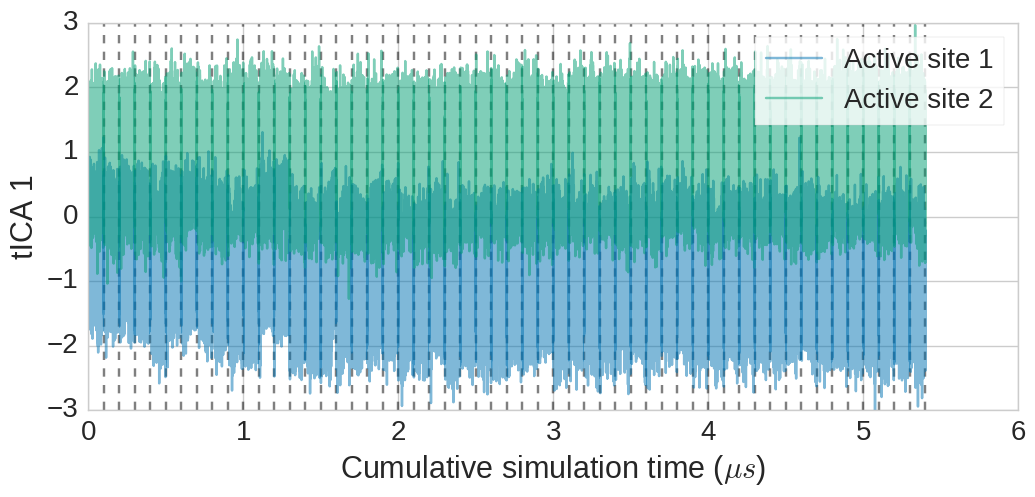

In [189]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('colorblind', 2)
t = np.arange(txx1.shape[0])*to_ns/1000
n_comps = 1
n_frames = int(t_max/to_ns)
stride=1
space=1
with sns.plotting_context('notebook', font_scale=2):
    fig, axes = plt.subplots(nrows=n_comps, sharex=True, figsize=(12,5))
    sns.set_style('whitegrid')
    for i in range(n_comps):
        if n_comps > 1:
            ax = axes[i]
        else:
            ax = axes
        for k in range(txx1.shape[0]//n_frames):
            start, stop = k*n_frames, min(frames_tot, (k+1)*n_frames)
            times = t[start:stop:stride]
            ax.plot(times, txx1[start:stop:stride, i], label='Active site 1', alpha=0.5)
            ax.plot(times, txx2[start:stop:stride, i], label='Active site 2', alpha=0.5)
            ax.vlines(x=times[-1], ymin=-3,ymax=3, color='k', linestyle='--', alpha=0.5)
            ax.set_ylabel('tICA {}'.format(i+1))
            ax.set_xlabel('Cumulative simulation time ($\mu s$)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], frameon=True, framealpha=0.8)
    ax.set_ylim((-3,3))
plt.savefig('tICA_Trajectory.pdf')

In [260]:
# print(len(ctrajs))
split=10
trajs_idx = []
for i in range(len(ctrajs)//split+1):
    print(i,min(len(ctrajs), (i+1)*split))
    trajs_idx.append((i+1)*split)


0 10
1 20
2 30
3 40
4 50
5 60
6 70
7 80
8 90
9 100
10 108


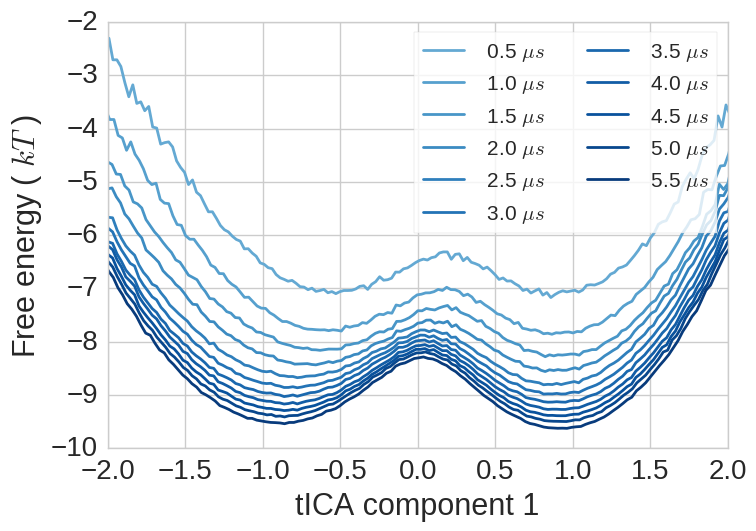

In [270]:
to_mu = to_ns/1000
n = len(trajs_idx)*2
cols = sns.color_palette('Blues', n)

with sns.plotting_context('notebook', font_scale=2):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()

    for jdx, traj_idx in enumerate(trajs_idx):
        txx = np.concatenate(ttrajs[:traj_idx])
        z,bins = np.histogram(txx[:,0],bins=200)
        time = trajs_idx[jdx]*n_frames*to_mu/(2)
        F = -np.log(z)

        ax.plot(bins[1:], F, lw='2', c=cols[int(n/2)+jdx], label='{0:4.1f} $\mu s$'.format(time))
        ax.set_xlim((-2,2))
        ax.set_ylim((-10,-2))

        ax.set_ylabel('Free energy ( $kT$ )')
        ax.set_xlabel('tICA component 1')
#     handles, labels = ax.get_legend_handles_labels()
    ax.legend(frameon=True, framealpha=0.8, ncol=2, fontsize=15)
plt.savefig('tICA_FreeEnergy.pdf')

In [58]:
# # histogram data
# # cols = sns.color_palette('colorblind', 3)
# from itertools import combinations

# fig, axes = plt.subplots(nrows=3, figsize=(5,8))
# combs = combinations(range(3), 2)

# with sns.plotting_context('notebook', font_scale=2):
#     for idx, (i, j) in enumerate(combs): 
#         z,x,y = np.histogram2d(txx[:,i],txx[:,j], bins=100)
#         z = z+0.01
#         # compute free energies
#         F = -np.log(z)
#         # contour plot
#         extent = [-1,1,-1,1] #[x[0], x[-1], y[0], y[-1]]
#         conts = 30
#         sns.set_style('white')
#         axes[idx].contourf(F.T, conts, cmap='viridis_r',extent=extent)
#         axes[idx].contour(F.T, conts, extent=extent)

#         axes[idx].set_xlabel('tICA {}'.format(i+1))
#         axes[idx].set_ylabel('tICA {}'.format(j+1))
#         axes[idx].tick_params(
#             axis='both',          # changes apply to the x-axis
#             which='both',      # both major and minor ticks are affected
#             bottom='off',      # ticks along the bottom edge are off
#             top='off', 
#             left='off',
#             labelbottom='off', 
#             labelleft='off')
# plt.tight_layout()

## Cluster

In [163]:
from msmbuilder.cluster import MiniBatchKMeans
cluster = MiniBatchKMeans(n_clusters=int(np.sqrt(frames_tot)))
ctrajs = cluster.fit_transform(ttrajs)

## Fit MSM

In [271]:
from msmbuilder.msm import MarkovStateModel
lags = np.arange(int(80/to_ns), int(99/to_ns), int(1/to_ns))
print(lags)
tscales = np.zeros((lags.shape[0], len(trajs_idx)))
for idx, lag in enumerate(lags):
    for jdx, traj_idx in enumerate(trajs_idx):
        msm = MarkovStateModel(n_timescales=1, lag_time=lag)
        msm.fit(ctrajs[0:traj_idx])
        tscales[idx, jdx] = msm.timescales_[0]


[8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400
 9500 9600 9700 9800]
MSM contains 53 strongly connected components above weight=0.00. Component 39 selected, with population 99.415000%
MSM contains 13 strongly connected components above weight=0.00. Component 7 selected, with population 99.925000%
MSM contains 3 strongly connected components above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.00

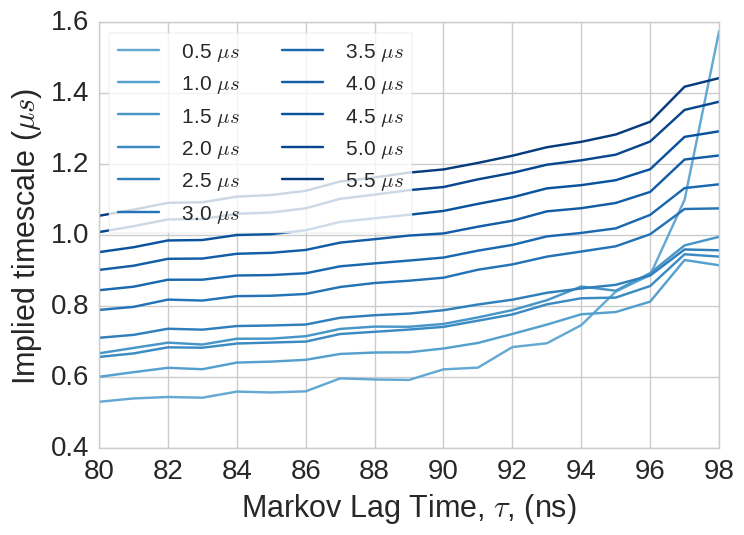

In [279]:
n = tscales.shape[1]*2
to_mu = to_ns/1000
cols = sns.color_palette('Blues', n)
with sns.plotting_context('notebook', font_scale=2):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    for idx in range(len(trajs_idx)):
        time = trajs_idx[idx]*n_frames*to_mu/(2)
        ax.plot(lags*to_ns, tscales.T[idx]*to_mu, c=cols[int(n/2) + idx], label='{0:4.1f} $\mu s$'.format(time))
    ax.legend(frameon=True, framealpha=0.8, ncol=2, fontsize=15, loc=2)
    ax.set_xlabel(r'Markov Lag Time, $\tau$, (ns)')
    ax.set_ylabel(r'Implied timescale ($\mu s$)')
    # ax.set_yscale('log')
plt.savefig('Lag-time-convergence.pdf')

In [280]:
msm = MarkovStateModel(n_timescales=1, lag_time=int(50/to_ns))
msm.fit(ctrajs)

MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=5000, n_timescales=1,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

## Lump states using PCCA

In [281]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=2)
macro_trajs = pcca.transform(ctrajs, mode='fill')


Optimization terminated successfully.
         Current function value: -1.905600
         Iterations: 9
         Function evaluations: 26


(-0.1, 1.1)

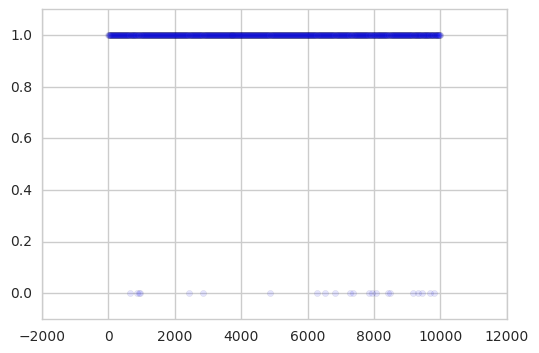

In [289]:
trajn = 1
plt.scatter(np.arange(macro_trajs[trajn].shape[0])[::10],macro_trajs[trajn][::10], alpha=0.1)
plt.ylim((-0.1,1.1))

## Plot O-H distances and cluster


In [296]:
macro = np.concatenate(macro_trajs)
macro.shape


(1080000,)

In [297]:
total_traj = md.join(traj for traj in trajs)

In [298]:
total_traj.n_frames

1080000

In [300]:
for state in range(2):
    inds = np.where(macro==state)[0]
    sample_inds = np.random.choice(inds, 200)
    traj = md.join(total_traj[i] for i in sample_inds)
    traj.save("{}/{}.nc".format('trajectories', state))

In [335]:
import pandas as pd
all_dfs = []

for j in [2,3]:
    for i in [0,1]:
        p1 = traj.topology.select("(resname TTW and name HI{}) or (resname ASP and name OD1)".format(j))
        p2 = traj.topology.select("(resname TTW and name HI{}) or (resname ASP and name OD2)".format(j))
        pairs = np.array([p1, p2])
        distances = md.compute_distances(total_traj, pairs)*10 # Nanometers to Angstroms
        df = pd.DataFrame(data=distances, columns=['OD1','OD2'])
        df['PCCA_state'] = i
        df['H-donor'] = 'HI{}'.format(j)
        df = pd.melt(frame=df, id_vars=['PCCA_state', 'H-donor'], var_name='H-acceptor', value_name='Distance')
        all_dfs.append(df)

df = pd.concat(all_dfs)
df.head()

,PCCA_state,H-donor,H-acceptor,Distance
0,0,HI2,OD1,7.757235
1,0,HI2,OD1,6.927049
2,0,HI2,OD1,7.726331
3,0,HI2,OD1,8.285743
4,0,HI2,OD1,8.093565


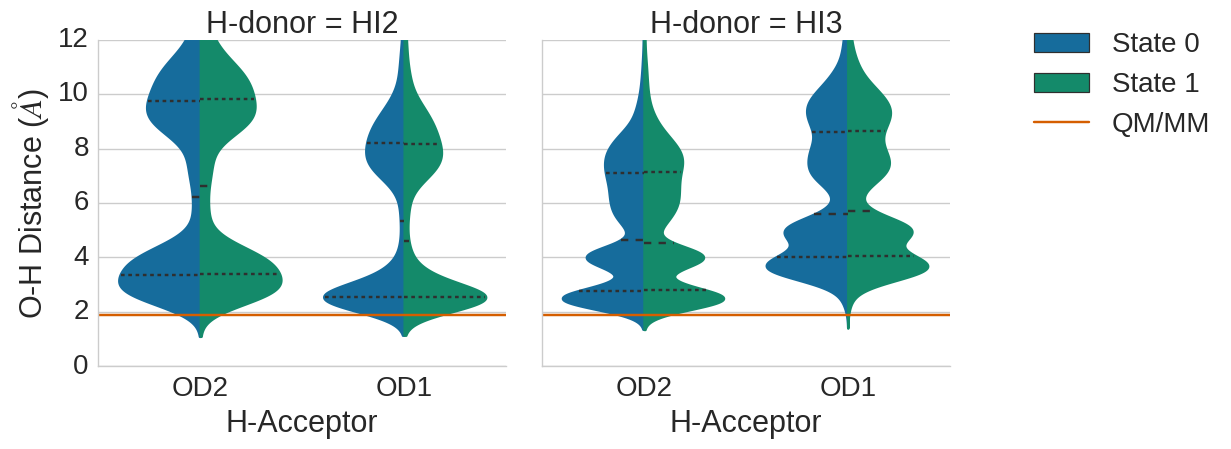

In [358]:
hod2 = 1.9
sample = df.sample(n=100000)
with sns.plotting_context('notebook', font_scale=2):
    sns.set_style('whitegrid')
    cols = sns.color_palette('colorblind', 3)
    grid = sns.FacetGrid(sample, col='H-donor', size=5, legend_out=True, )
    grid = grid.map(sns.violinplot, 'H-acceptor' , 'Distance','PCCA_state', palette=cols[:2], alpha=0.5, 
                    inner='quartile', gridsize=1000, split=True)
    for ax in grid.axes.flatten():
        ax.hlines(hod2, xmin=-1, xmax=2.5, colors=cols[-1], label='QM/MM')
    
    handles, labels = grid.axes.flatten()[1].get_legend_handles_labels()
    new_labels = ['State {}'.format(x) for x in labels[:2]]
    new_labels = new_labels + [labels[-1]]
    
    grid.axes.flatten()[1].legend(labels=new_labels, handles=handles, bbox_to_anchor=(1.7,1.1))
    grid.set_ylabels(r'O-H Distance ($\AA$)')
    grid.set_xlabels('H-Acceptor')
    grid.set(ylim=(0,12))

    plt.savefig('OH_distance.pdf')
